[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/notebooks/omgmega_example.ipynb)

# Optimizing with OMG-MEGA in Jax

This notebook shows how to use QDax to find diverse and performing parameters on the Rastrigin problem with [OMG-MEGA](https://arxiv.org/pdf/2106.03894.pdf).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an omg-mega emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [1]:
import jax 
import jax.numpy as jnp
import math

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.omg_mega_emitter import OMGMEGAEmitter
from qdax.core.containers.mapelites_repertoire import compute_euclidean_centroids, MapElitesRepertoire
from qdax.utils.plotting import plot_map_elites_results

from typing import Dict

## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/abs/2106.03894).

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 20000 #@param {type:"integer"}
num_dimensions = 1000 #@param {type:"integer"}
num_centroids = 10000 #@param {type:"integer"}
num_descriptors = 2 #@param {type:"integer"}
sigma_g=10 #@param {type:"number"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
batch_size = 36 #@param {type:"integer"}
init_population_size = 100 #@param {type:"integer"}
#@markdown ---

## Defines the scoring function: rastrigin

As we are in the Differentiable QD setting, the scoring function does not only retrieve the fitness and descriptors, but also the gradients.

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    return -(10 * x.shape[-1] + jnp.sum((x+minval*0.4)**2 - 10 * jnp.cos(2 * jnp.pi * (x+minval*0.4))))

def clip(x: jnp.ndarray):
    return x*(x<=maxval)*(x>=+minval) + maxval/x*((x>maxval)+(x<+minval))

def _rastrigin_descriptor_1(x: jnp.ndarray):
    return jnp.mean(clip(x[:x.shape[0]//2]))

def _rastrigin_descriptor_2(x: jnp.ndarray):
    return jnp.mean(clip(x[x.shape[0]//2:]))

def rastrigin_descriptors(x: jnp.ndarray):
    return jnp.array([_rastrigin_descriptor_1(x), _rastrigin_descriptor_2(x)])

rastrigin_grad_scores = jax.grad(rastrigin_scoring)

In [4]:
def scoring_function(x):
    fitnesses, descriptors = rastrigin_scoring(x), rastrigin_descriptors(x)
    gradients = jnp.array([rastrigin_grad_scores(x), jax.grad(_rastrigin_descriptor_1)(x), jax.grad(_rastrigin_descriptor_2)(x)]).T
    gradients = jnp.nan_to_num(gradients)
    return fitnesses, descriptors, {"gradients": gradients}

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [5]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * maxval)
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * maxval * 0.4)


def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define the initial population, the emitter and the MAP Elites instance

The emitter is defined using the OMGMEGA emitter class. This emitter is given to a MAP-Elites instance to create an instance of the OMG-MEGA algorithm. 

In [18]:
random_key = jax.random.PRNGKey(0)

# defines the population
random_key, subkey = jax.random.split(random_key)
initial_population = jax.random.normal(subkey, shape=(init_population_size, num_dimensions))

sqrt_centroids = int(math.sqrt(num_centroids)) # 2-D grid 
grid_shape = (sqrt_centroids, sqrt_centroids)
centroids = compute_euclidean_centroids(
    grid_shape = grid_shape,
    minval = minval,
    maxval = maxval
) 

# defines the emitter
emitter = OMGMEGAEmitter(
    batch_size=batch_size,
    sigma_g=sigma_g,
    num_descriptors=num_descriptors,
    centroids=centroids
)

# create the MAP Elites instance
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn
)

## Initialise MAP Elites

In [19]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

## Run MAP Elites iterations

In [20]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

CPU times: user 17.7 s, sys: 10.7 ms, total: 17.7 s
Wall time: 14.9 s


## Plot the results

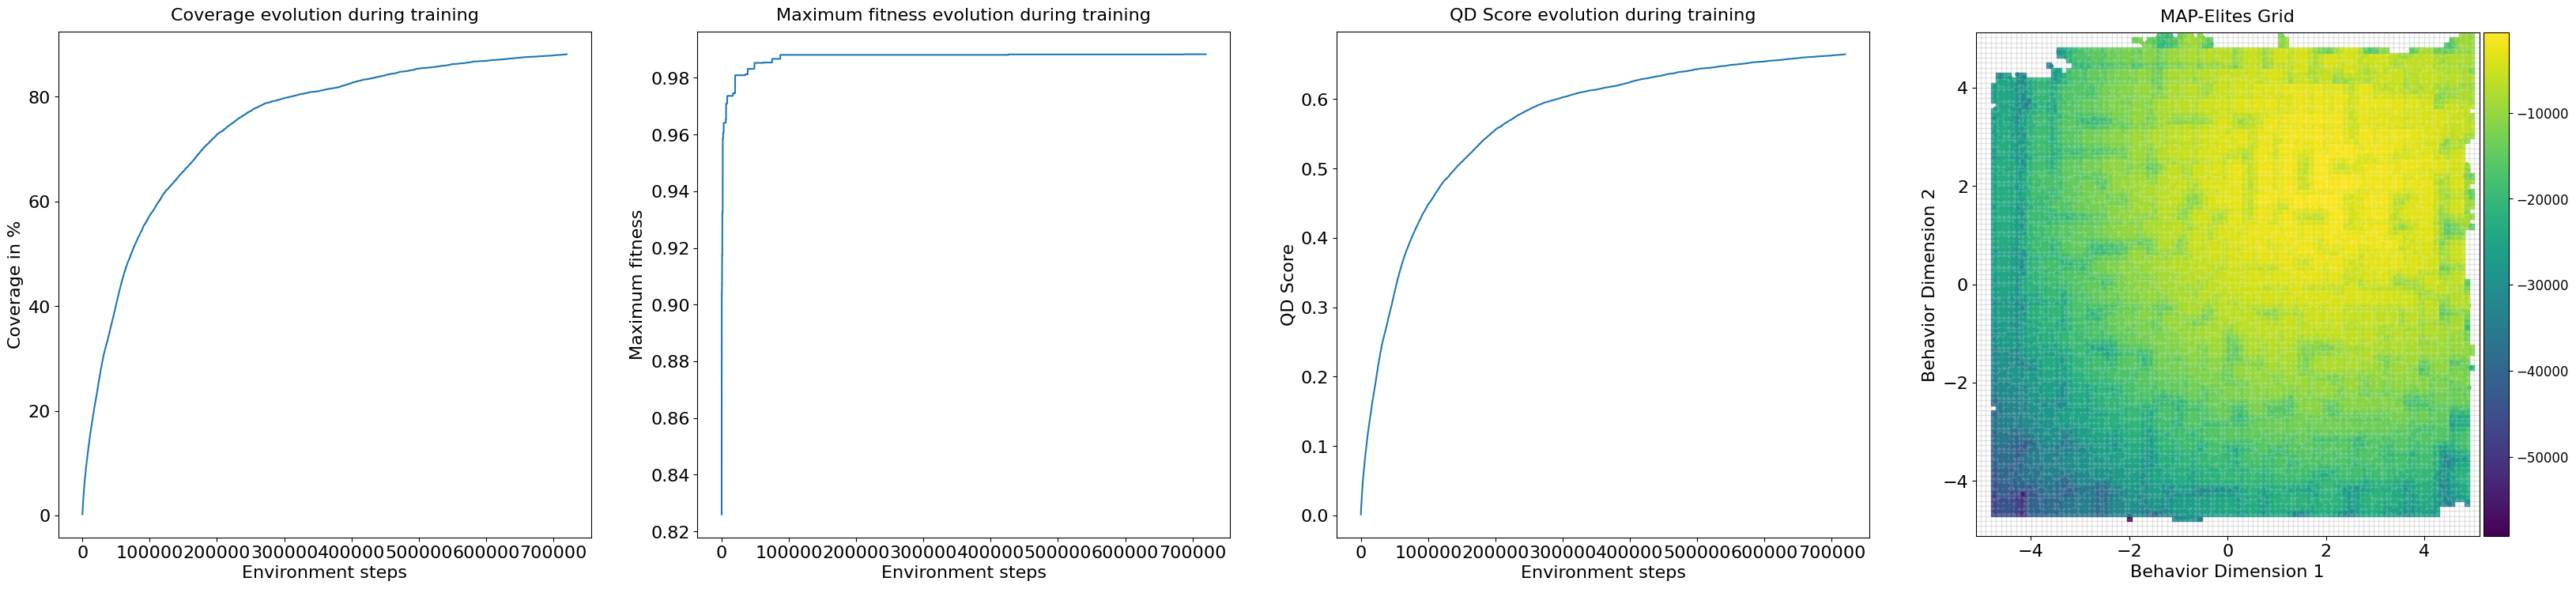

In [21]:
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=minval, max_bd=maxval
)